In [1]:
import pandas as pd
import matplotlib.pyplot as plt

In [2]:
import torch
torch.set_default_dtype(torch.float64)

import numpy as np

In [3]:
df = pd.read_hdf('freesolv_with_samples.h5')

In [4]:
from openmmtools.constants import kB
from simtk import unit
from espaloma.units import DISTANCE_UNIT, ENERGY_UNIT

temperature = 300 * unit.kelvin
kT = kB * temperature

# conversion from espaloma energy unit to kT
to_kT = 1.0 * ENERGY_UNIT / kT
to_kT

Using backend: pytorch


1052.5821686494048

In [5]:
df['offmol']['mobley_1017962'].partial_charges

Quantity(value=array([-0.09266   , -0.07967   , -0.07829   , -0.07824   , -0.12671   ,
        0.63147002, -0.53658998, -0.44984001,  0.12808   ,  0.03392   ,
        0.03392   ,  0.03392   ,  0.04138   ,  0.04138   ,  0.03957   ,
        0.03957   ,  0.05656   ,  0.05656   ,  0.07839   ,  0.07839   ,
        0.04963   ,  0.04963   ,  0.04963   ]), unit=elementary charge)

In [6]:
from scipy.spatial.distance import pdist, squareform

# these are espaloma units of bohr
df['distance_matrices'] = None

for key in df.index:
    xyz = (df['quick_xyz'][key] * unit.nanometer).value_in_unit(DISTANCE_UNIT)
    distance_matrices = [torch.tensor(squareform(pdist(conf))) for conf in xyz]
    distance_matrices = torch.stack(distance_matrices)
    df['distance_matrices'][key] = distance_matrices

In [7]:
df.columns

Index(['SMILES',
       'iupac name (or alternative if IUPAC is unavailable or not parseable by OEChem)',
       'experimental value (kcal/mol)', 'experimental uncertainty (kcal/mol)',
       'Mobley group calculated value (GAFF) (kcal/mol)',
       'calculated uncertainty (kcal/mol)',
       'experimental reference (original or paper this value was taken from)',
       'calculated reference', 'text notes.', 'offmol',
       'serialized_openmm_system', 'xyz', 'quick_xyz', 'distance_matrices'],
      dtype='object')

In [8]:
from espaloma.mm.implicit import gbsa_obc2_energy

In [9]:
def compute_obc2_energies(
    distance_matrices,
    radii, scales, charges,
    alpha=0.8, beta=0.0, gamma=2.909125
):
    N = len(distance_matrices)
    E_s = torch.zeros(N)
    for i in range(N):
        E_s[i] += gbsa_obc2_energy(
            distance_matrices[i],
            radii, scales, charges, 
            alpha, beta, gamma,
        )
    return E_s

In [10]:
offmol = df['offmol'][key]

In [11]:
from espaloma.redux.nn import TAG, MLP
from espaloma.redux.symmetry import ValenceModel, Readouts, elements

# radii, scales
atom_dim = 2

def initialize(hidden_dim=128, node_dim=128):
    node_representation = TAG(in_dim=len(elements), hidden_dim=hidden_dim, out_dim=node_dim)
    readouts = Readouts(atoms=MLP(node_dim, atom_dim), bonds=MLP(2 * node_dim, 2), angles=MLP(3 * node_dim, 2),
                        propers=MLP(4 * node_dim, 6), impropers=MLP(4 * node_dim, 6))
    graph_model = ValenceModel(node_representation, readouts)
    return graph_model


def predict_obc2_params(offmol, graph_model):
    """output of graph net's atom representation will initially be near zero, just offset by a constant"""
    params = graph_model.forward(offmol)
    radii = params.atoms[:,0] + 2
    scales = params.atoms[:,1] + 1
    return radii, scales

In [12]:
def one_sided_exp(w):
    delta_f = - (torch.logsumexp(- w, dim=(0,)) - np.log(len(w)))
    return delta_f

In [13]:
def predict_on_key(key: str, graph_model, batch_size: int = 25, verbose: bool = False) -> float:
    offmol = df['offmol'][key]
    
    radii, scales = predict_obc2_params(offmol, graph_model)
    
    distance_matrices = df['distance_matrices'][key]
    inds = np.random.randint(0, len(distance_matrices), size=batch_size)
    
    charges = torch.tensor(offmol.partial_charges / unit.elementary_charge)
    
    obc2_energies = compute_obc2_energies(distance_matrices[inds], radii, scales, charges)
    if verbose:
        print(obc2_energies)
    w = obc2_energies * to_kT
    pred_delta_f = one_sided_exp(w)
    
    return pred_delta_f

In [14]:
np.random.seed(0)
inds = list(df.index)
np.random.shuffle(inds)
train_inds = inds[::2]
valid_inds = inds[1::2]
len(train_inds), len(valid_inds)

(321, 321)

In [15]:
train_inds

['mobley_2422586',
 'mobley_7688753',
 'mobley_9100956',
 'mobley_3715043',
 'mobley_3234716',
 'mobley_5282042',
 'mobley_7415647',
 'mobley_7608462',
 'mobley_6743808',
 'mobley_8789465',
 'mobley_7578802',
 'mobley_8052240',
 'mobley_2802855',
 'mobley_6854178',
 'mobley_2178600',
 'mobley_1977493',
 'mobley_1733799',
 'mobley_7608435',
 'mobley_4762983',
 'mobley_3266352',
 'mobley_9028462',
 'mobley_8614858',
 'mobley_397645',
 'mobley_4506634',
 'mobley_994483',
 'mobley_1760914',
 'mobley_646007',
 'mobley_1735893',
 'mobley_755351',
 'mobley_5518547',
 'mobley_8311321',
 'mobley_1261349',
 'mobley_3761215',
 'mobley_6303022',
 'mobley_3269819',
 'mobley_2972345',
 'mobley_7610437',
 'mobley_2681549',
 'mobley_1855337',
 'mobley_4305650',
 'mobley_4694328',
 'mobley_1019269',
 'mobley_929676',
 'mobley_8467917',
 'mobley_8861672',
 'mobley_1139153',
 'mobley_9883303',
 'mobley_1328465',
 'mobley_676247',
 'mobley_778352',
 'mobley_3843583',
 'mobley_2881590',
 'mobley_2659552',


In [16]:
from tqdm import tqdm

In [17]:
graph_model = initialize()

preds = []
for key in tqdm(train_inds):
    preds.append(predict_on_key(key, graph_model))

100%|██████████| 321/321 [00:14<00:00, 22.27it/s]


In [18]:
graph_model = initialize()

In [19]:
learning_rate = 1e-4
optimizer = torch.optim.Adam(graph_model.parameters(), lr=learning_rate)

In [20]:
# fit to a small chunk of the data
keys = train_inds[:10]
keys

['mobley_2422586',
 'mobley_7688753',
 'mobley_9100956',
 'mobley_3715043',
 'mobley_3234716',
 'mobley_5282042',
 'mobley_7415647',
 'mobley_7608462',
 'mobley_6743808',
 'mobley_8789465']

In [21]:
from openforcefield.topology import Molecule

In [22]:
df.offmol[keys[1]]

NGLWidget()

In [23]:
predict_dict = dict()
for key in tqdm(keys):
    predict_dict[key] = predict_on_key(key, graph_model)

100%|██████████| 10/10 [00:00<00:00, 25.12it/s]


In [24]:
x = np.array([predict_dict[key].detach() * kT / unit.kilocalorie_per_mole for key in keys])
y = [df['experimental value (kcal/mol)'][key] for key in keys]

In [25]:
x[0], y[0]

(-4.706119994343831, -1.66)

Text(0, 0.5, 'reference (kcal/mol)')

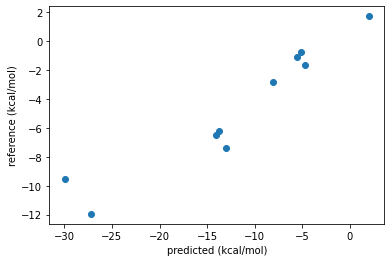

In [26]:
import matplotlib.pyplot as plt
plt.scatter(x, y)
plt.xlabel('predicted (kcal/mol)')
plt.ylabel('reference (kcal/mol)')

In [27]:
predictions = []

batch_losses = []
trange = tqdm(range(1000))

n_mols_per_batch = 10
n_snapshots_per_mol = 10


for t in trange:
    #keys = np.random.choice(train_inds, size=n_mols_per_batch)
    
    L = 0.0
    for key in keys:
        # make a free energy prediction using a random subset of snapshots for each key
        prediction  = predict_on_key(key, graph_model, n_snapshots_per_mol)
        target = (df['experimental value (kcal/mol)'][key] * unit.kilocalorie_per_mole) / kT
    
        # TODO: modify loss function to depend on experimental error and simulation error
        L += (prediction - target)**2
        predictions.append((t, key, prediction))
    
    L /= len(keys)

    optimizer.zero_grad()
    L.backward()
    optimizer.step()
    
    batch_losses.append(L.detach().numpy())
    rmse_in_kcalmol = np.sqrt(batch_losses[-1] * kT / unit.kilocalories_per_mole)
    trange.set_postfix(rmse_in_kcalmol=rmse_in_kcalmol)

100%|██████████| 1000/1000 [06:05<00:00,  2.74it/s, rmse_in_kcalmol=0.754]


In [28]:
rmse_in_kcalmol = [np.sqrt(b * kT / unit.kilocalories_per_mole) for b in batch_losses]

(0.0, 12.770631036114144)

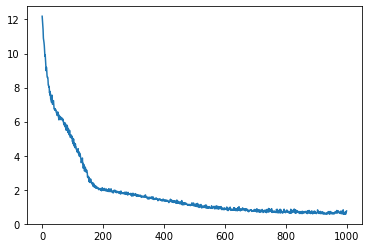

In [29]:
plt.plot(rmse_in_kcalmol)
plt.ylim(0,)

In [30]:
np.mean(rmse_in_kcalmol[:100]), np.mean(rmse_in_kcalmol[-100:])

(7.052731514648437, 0.650036070536531)

In [31]:
final_predict_dict = dict()
for key in tqdm(keys):
    final_predict_dict[key] = predict_on_key(key, graph_model, verbose=True)

 40%|████      | 4/10 [00:00<00:00, 15.79it/s]

tensor([-0.0011, -0.0010, -0.0008, -0.0008, -0.0010, -0.0010, -0.0009, -0.0008,
        -0.0010, -0.0008, -0.0010, -0.0007, -0.0009, -0.0006, -0.0008, -0.0009,
        -0.0008, -0.0009, -0.0010, -0.0009, -0.0007, -0.0007, -0.0008, -0.0011,
        -0.0010], grad_fn=<CopySlices>)
tensor([-0.0152, -0.0158, -0.0149, -0.0159, -0.0136, -0.0154, -0.0159, -0.0129,
        -0.0146, -0.0151, -0.0161, -0.0148, -0.0154, -0.0146, -0.0147, -0.0145,
        -0.0134, -0.0152, -0.0158, -0.0140, -0.0142, -0.0126, -0.0132, -0.0135,
        -0.0150], grad_fn=<CopySlices>)
tensor([0.0018, 0.0019, 0.0018, 0.0018, 0.0019, 0.0018, 0.0019, 0.0019, 0.0018,
        0.0018, 0.0018, 0.0019, 0.0018, 0.0019, 0.0018, 0.0018, 0.0019, 0.0019,
        0.0019, 0.0019, 0.0019, 0.0019, 0.0019, 0.0019, 0.0019],
       grad_fn=<CopySlices>)
tensor([-0.0056, -0.0042, -0.0050, -0.0049, -0.0053, -0.0050, -0.0053, -0.0055,
        -0.0052, -0.0054, -0.0052, -0.0053, -0.0052, -0.0055, -0.0047, -0.0052,
        -0.0052, -0.0053, 

 80%|████████  | 8/10 [00:00<00:00, 16.66it/s]

tensor([-0.0007, -0.0006, -0.0006, -0.0008, -0.0005, -0.0007, -0.0007, -0.0004,
        -0.0006, -0.0007, -0.0006, -0.0007, -0.0004, -0.0008, -0.0011, -0.0012,
        -0.0010, -0.0009, -0.0010, -0.0015, -0.0007, -0.0010, -0.0009, -0.0007,
        -0.0007], grad_fn=<CopySlices>)
tensor([-0.0112, -0.0117, -0.0110, -0.0117, -0.0113, -0.0108, -0.0120, -0.0108,
        -0.0119, -0.0107, -0.0110, -0.0110, -0.0112, -0.0099, -0.0116, -0.0108,
        -0.0121, -0.0111, -0.0116, -0.0120, -0.0110, -0.0110, -0.0116, -0.0107,
        -0.0113], grad_fn=<CopySlices>)
tensor([-0.0194, -0.0164, -0.0186, -0.0181, -0.0201, -0.0175, -0.0162, -0.0154,
        -0.0172, -0.0164, -0.0154, -0.0204, -0.0187, -0.0151, -0.0172, -0.0188,
        -0.0173, -0.0157, -0.0160, -0.0170, -0.0206, -0.0170, -0.0182, -0.0213,
        -0.0146], grad_fn=<CopySlices>)
tensor([-0.0019, -0.0021, -0.0019, -0.0017, -0.0022, -0.0016, -0.0018, -0.0018,
        -0.0020, -0.0019, -0.0020, -0.0019, -0.0019, -0.0019, -0.0019, -0.0019,


100%|██████████| 10/10 [00:00<00:00, 17.48it/s]

tensor([-0.0097, -0.0095, -0.0104, -0.0100, -0.0097, -0.0095, -0.0105, -0.0098,
        -0.0099, -0.0100, -0.0101, -0.0104, -0.0103, -0.0104, -0.0102, -0.0102,
        -0.0089, -0.0097, -0.0095, -0.0100, -0.0096, -0.0101, -0.0104, -0.0095,
        -0.0104], grad_fn=<CopySlices>)
tensor([-0.0111, -0.0100, -0.0096, -0.0095, -0.0105, -0.0097, -0.0096, -0.0107,
        -0.0104, -0.0094, -0.0101, -0.0094, -0.0095, -0.0098, -0.0103, -0.0096,
        -0.0098, -0.0097, -0.0096, -0.0096, -0.0100, -0.0094, -0.0097, -0.0091,
        -0.0096], grad_fn=<CopySlices>)


In [32]:
x = np.array([final_predict_dict[key].detach() * kT / unit.kilocalorie_per_mole for key in keys])
y = [df['experimental value (kcal/mol)'][key] for key in keys]

Text(0.5, 1.0, 'GBSA hydration free energies')

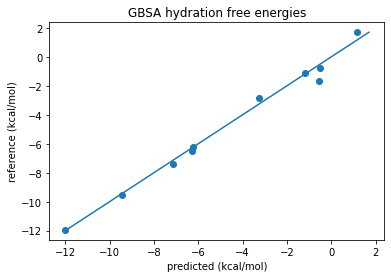

In [33]:
plt.scatter(x, y)
plt.xlabel('predicted (kcal/mol)')
plt.ylabel('reference (kcal/mol)')
plt.plot([min(y), max(y)], [min(y), max(y)])

plt.title('GBSA hydration free energies')

In [34]:
min(x), max(x)

(-12.032419477932498, 1.1626250789489185)

In [50]:
graph_model = initialize(hidden_dim=32, node_dim=32)
learning_rate = 1e-3
optimizer = torch.optim.Adam(graph_model.parameters(), lr=learning_rate)

In [51]:
keys = train_inds
len(keys)

321

In [ ]:
predictions = []

batch_losses = []
trange = tqdm(range(1000))

n_mols_per_batch = 10
n_snapshots_per_mol = 10


for t in trange:
    
    # optionally subsample the training set...
    keys = np.random.choice(train_inds, size=n_mols_per_batch)
    
    L = 0.0
    for key in keys:
        # make a free energy prediction using a random subset of snapshots for each key
        prediction  = predict_on_key(key, graph_model, n_snapshots_per_mol)
        target = (df['experimental value (kcal/mol)'][key] * unit.kilocalorie_per_mole) / kT
    
        # TODO: modify loss function to depend on experimental error and simulation error
        L += (prediction - target)**2
        predictions.append((t, key, prediction))
    
    L /= len(keys)

    optimizer.zero_grad()
    L.backward()
    optimizer.step()
    
    batch_losses.append(L.detach().numpy())
    rmse_in_kcalmol = np.sqrt(batch_losses[-1] * kT / unit.kilocalories_per_mole)
    trange.set_postfix(rmse_in_kcalmol=rmse_in_kcalmol)

In [38]:
rmse_in_kcalmol = [np.sqrt(b * kT / unit.kilocalories_per_mole) for b in batch_losses]

(0.0, 65.76610916306065)

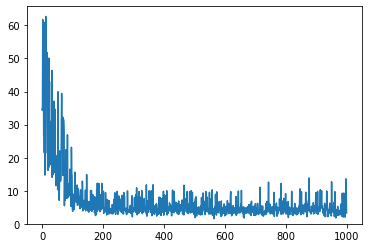

In [39]:
plt.plot(rmse_in_kcalmol)
plt.ylim(0,)

In [42]:
final_predict_dict = dict()
for key in tqdm(df.index):
    final_predict_dict[key] = predict_on_key(key, graph_model)

100%|██████████| 642/642 [00:26<00:00, 24.18it/s]


In [43]:
splits = {
    'training': train_inds,
    'validation': valid_inds,
}

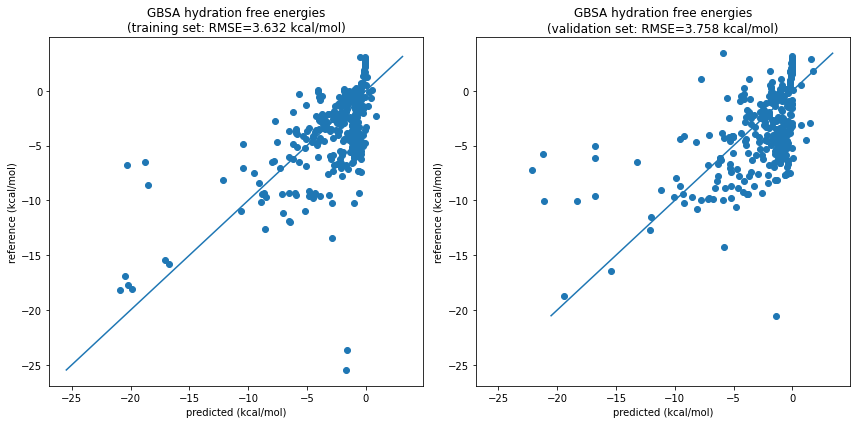

In [45]:
plt.figure(figsize=(12,6))
ax = None

for i, split_name in enumerate(splits):
    split = splits[split_name]
    x = np.array([final_predict_dict[key].detach() * kT / unit.kilocalorie_per_mole for key in split])
    y = np.array([df['experimental value (kcal/mol)'][key] for key in split])
    
    rmse = np.sqrt(np.mean((x - y)**2))
    
    ax = plt.subplot(1,2,i+1, sharex=ax, sharey=ax)
    plt.scatter(x, y)
    plt.xlabel('predicted (kcal/mol)')
    plt.ylabel('reference (kcal/mol)')
    plt.plot([min(y), max(y)], [min(y), max(y)])

    plt.title(f'GBSA hydration free energies\n({split_name} set: RMSE={rmse:.3f} kcal/mol)')
plt.tight_layout()

In [46]:
# comparable to the RMSE that would be obtained by predicting a constant
np.sqrt(np.mean((y - np.mean(y))**2))

3.6786284835937773

In [47]:
# TODO: refine this!